In [1]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import AgentDataset
from l5kit.evaluation import (
    compute_metrics_csv,
    create_chopped_dataset,
    read_gt_csv,
    write_pred_csv,
)
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from torch.utils.data import DataLoader
import torch
import models
from utils import convert_agent_coordinates_to_world_offsets

torch.multiprocessing.set_sharing_strategy("file_system")
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, REFERENCE_TRAJ_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import os

In [2]:

# Paths
data_path = "/home/elias.nehme1/Documents/lyft-motion-prediction/data"
config_path = (
    "/home/elias.nehme1/Documents/lyft-motion-prediction/src/train_config.yaml"
)

# Load data and model
lyft_data_module = models.LyftDataModule(data_path, config_path)

model = models.resnet_baseline.load_from_checkpoint(
    "/home/elias.nehme1/Documents/lyft-motion-prediction/epoch=0-v1.ckpt"
)


eval_base_path = "/home/elias.nehme1/Documents/lyft-motion-prediction/data/scenes/validate_chopped_100"
val_zarr_path = str(
    Path(eval_base_path)
    / Path(lyft_data_module.dm.require(lyft_data_module.val_cfg["key"])).name
)
val_mask_path = str(Path(eval_base_path) / "mask.npz")
val_gt_path = str(Path(eval_base_path) / "gt.csv")

val_zarr = ChunkedDataset(val_zarr_path).open()
val_mask = np.load(val_mask_path)["arr_0"]

# ===== INIT DATASET AND LOAD MASK
eval_dataset = AgentDataset(
    lyft_data_module.cfg, val_zarr, lyft_data_module.rasterizer, agents_mask=val_mask
)
val_dataloader = DataLoader(
    eval_dataset,
    shuffle=lyft_data_module.val_cfg["shuffle"],
    batch_size=lyft_data_module.val_cfg["batch_size"],
    num_workers=lyft_data_module.val_cfg["num_workers"],
)
print(eval_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16220    |  1622000   | 125423254  |    11733321   |      45.06      |        100.00        |        77.33         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


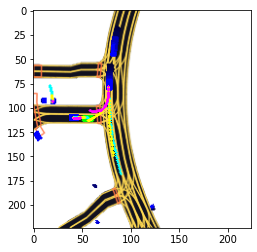

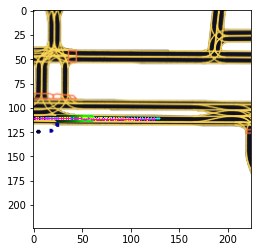

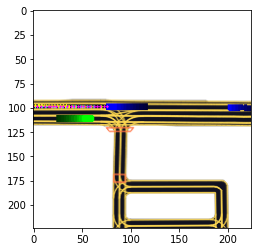

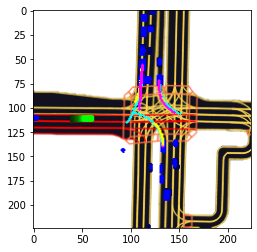

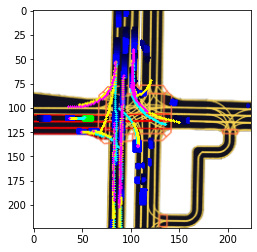

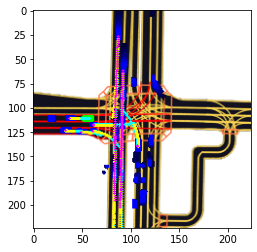

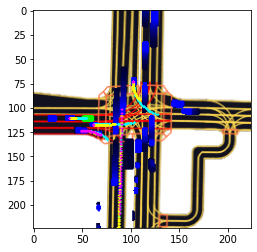

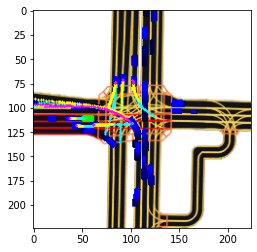

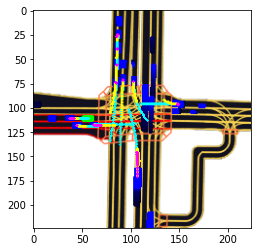

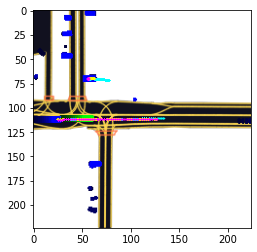

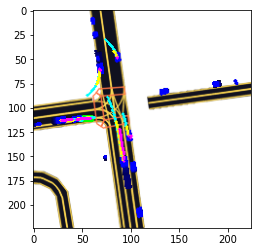

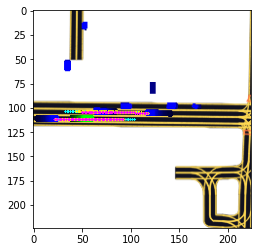

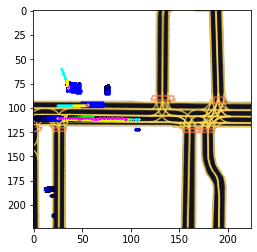

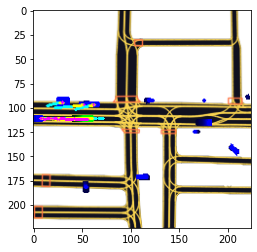

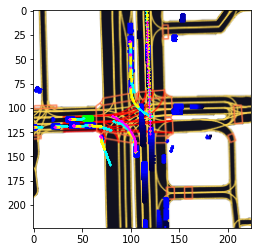

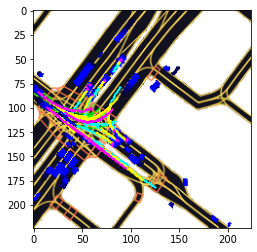

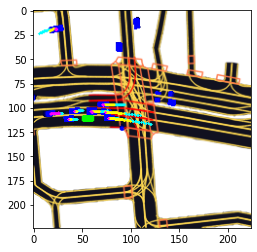

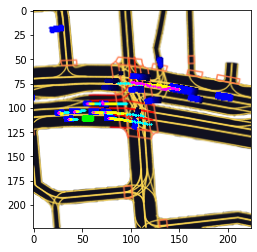

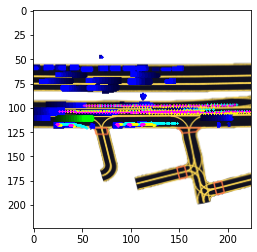

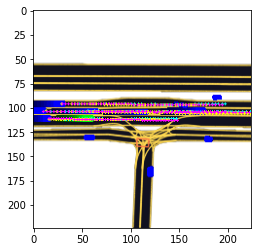

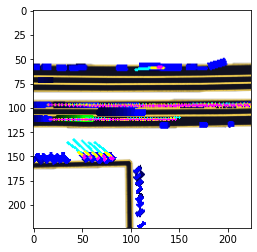

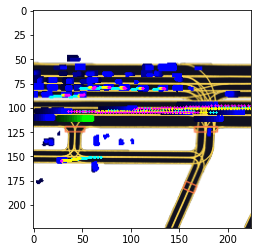

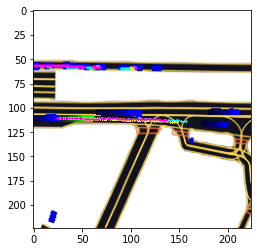

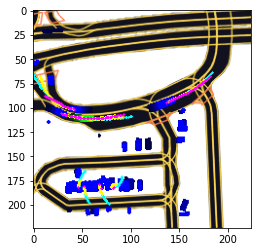

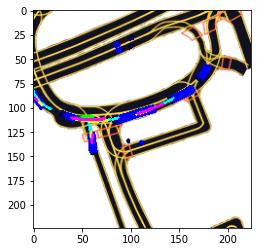

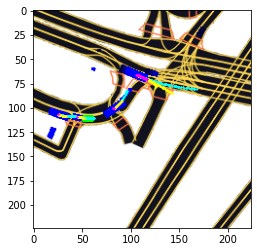

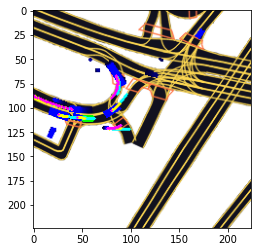

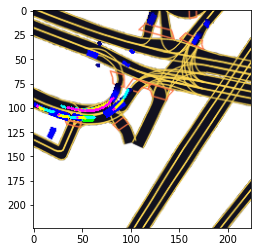

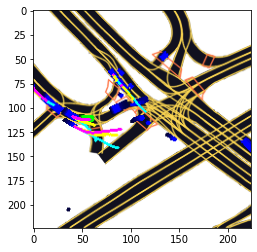

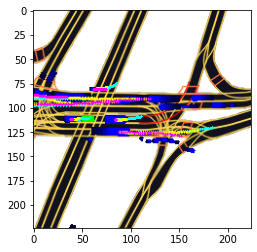

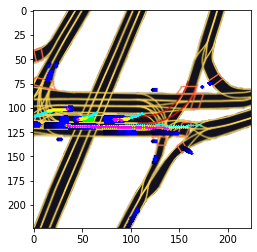

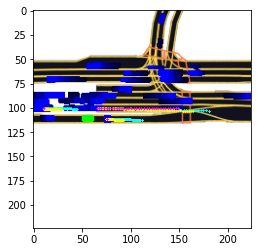

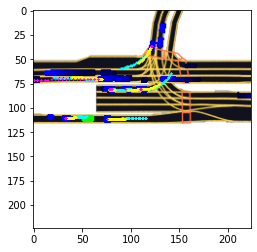

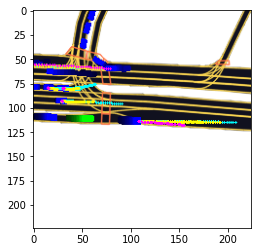

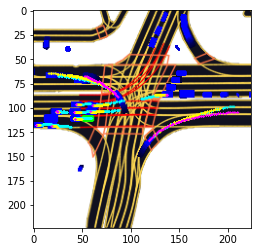

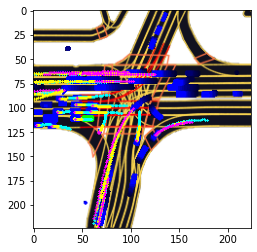

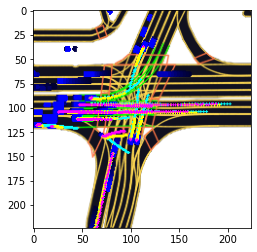

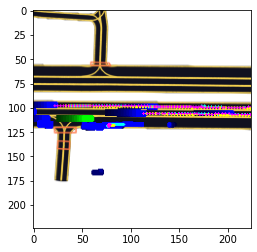

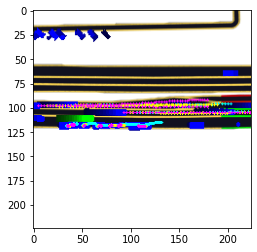

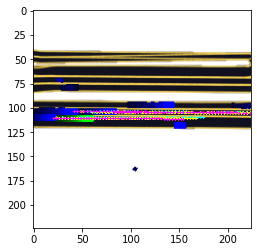

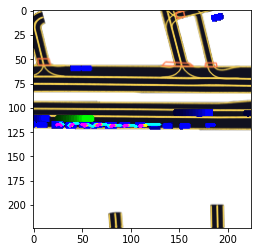

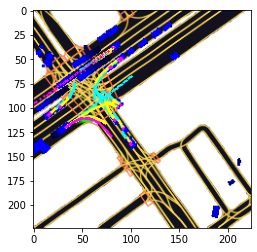

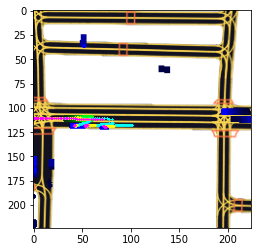

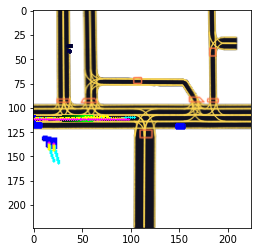

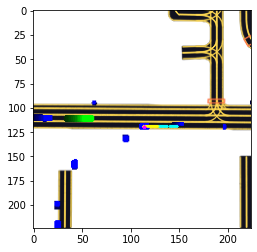

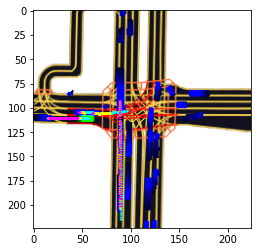

KeyboardInterrupt: 

In [4]:
device = torch.device("cuda")
model.to(device)
model.eval()
torch.set_grad_enabled(False)

eval_gt_path = "/home/elias.nehme1/Documents/lyft-motion-prediction/data/scenes/validate_chopped_100/gt.csv"

# build a dict to retrieve future trajectories from GT
gt_rows = {}
for row in read_gt_csv(eval_gt_path):
    gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]

eval_ego_dataset = EgoDataset(lyft_data_module.cfg, eval_dataset.dataset, lyft_data_module.rasterizer)

for frame_number in range(99, len(val_zarr.frames), 100):  # start from last frame of scene_0 and increase by 100
    agent_indices = eval_dataset.get_frame_indices(frame_number) 
    if not len(agent_indices):
        continue

    # get AV point-of-view frame
    data_ego = eval_ego_dataset[frame_number]
    im_ego = lyft_data_module.rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
    center = np.asarray(lyft_data_module.cfg["raster_params"]["ego_center"]) * lyft_data_module.cfg["raster_params"]["raster_size"]
    
    predicted_positions_1 = []
    predicted_positions_2 = []
    predicted_positions_3 = []

    target_positions = []

    for v_index in agent_indices:
        data_agent = eval_dataset[v_index]

        pred, confidences = model(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))

        pred_1 = pred[0][0].reshape(-1, 2).detach().cpu().numpy()
        pred_2 = pred[0][1].reshape(-1, 2).detach().cpu().numpy()
        pred_3 = pred[0][2].reshape(-1, 2).detach().cpu().numpy()


        # store absolute world coordinates
        predicted_positions_1.append(transform_points(pred_1, data_agent["world_from_agent"]))
        predicted_positions_2.append(transform_points(pred_2, data_agent["world_from_agent"]))
        predicted_positions_3.append(transform_points(pred_3, data_agent["world_from_agent"]))

        # retrieve target positions from the GT and store as absolute coordinates
        track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
        target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])


    # convert coordinates to AV point-of-view so we can draw them
    predicted_positions_1 = transform_points(np.concatenate(predicted_positions_1), data_ego["raster_from_world"])
    predicted_positions_2 = transform_points(np.concatenate(predicted_positions_2), data_ego["raster_from_world"])
    predicted_positions_3 = transform_points(np.concatenate(predicted_positions_3), data_ego["raster_from_world"])

    target_positions = transform_points(np.concatenate(target_positions), data_ego["raster_from_world"])

    draw_trajectory(im_ego, predicted_positions_1, PREDICTED_POINTS_COLOR) # TEAL
    draw_trajectory(im_ego, predicted_positions_2, REFERENCE_TRAJ_COLOR)   # YELLOW
    draw_trajectory(im_ego, predicted_positions_3, REFERENCE_TRAJ_COLOR)   # YELLOW
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)         # PURPLE

    plt.imshow(im_ego[::-1])
    plt.show()